# Library

In [50]:
import zipfile
import os
from google.colab import files, drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Load Data dari Kaggle

In [ ]:
!pip install kaggle

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kristinwulandari","key":"2d0e6b18219774fa204032f9f91b6c12"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d roopacalistus/superstore

Dataset URL: https://www.kaggle.com/datasets/roopacalistus/superstore
License(s): GNU Lesser General Public License 3.0
  0% 0.00/164k [00:00<?, ?B/s]
100% 164k/164k [00:00<00:00, 11.3MB/s]


In [ ]:
# Ekstrak file ZIP
with zipfile.ZipFile("superstore.zip", "r") as zip_ref:
    zip_ref.extractall("superstore_data")

os.listdir("superstore_data")

['SampleSuperstore.csv']

# EDA

In [37]:
df = pd.read_csv("superstore_data/SampleSuperstore.csv")
df

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,Second Class,Consumer,United States,Miami,Florida,33180,South,Furniture,Furnishings,25.2480,3,0.20,4.1028
9990,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Furniture,Furnishings,91.9600,2,0.00,15.6332
9991,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Technology,Phones,258.5760,2,0.20,19.3932
9992,Standard Class,Consumer,United States,Costa Mesa,California,92627,West,Office Supplies,Paper,29.6000,4,0.00,13.3200


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ship Mode     10000 non-null  object 
 1   Segment       10000 non-null  object 
 2   Country       10000 non-null  object 
 3   City          10000 non-null  object 
 4   State         10000 non-null  object 
 5   Postal Code   10000 non-null  int64  
 6   Region        10000 non-null  object 
 7   Category      10000 non-null  object 
 8   Sub-Category  10000 non-null  object 
 9   Sales         10000 non-null  float64
 10  Quantity      10000 non-null  int64  
 11  Discount      10000 non-null  float64
 12  Profit        10000 non-null  float64
dtypes: float64(3), int64(2), object(8)
memory usage: 1015.8+ KB


In [13]:
df.describe()
df.describe(include=['object'])

,Ship Mode,Segment,Country,City,State,Region,Category,Sub-Category
count,10000,10000,10000,10000,10000,10000,10000,10000
unique,4,3,1,531,49,4,3,17
top,Standard Class,Consumer,United States,New York City,California,West,Office Supplies,Binders
freq,5973,5195,10000,915,2002,3204,6029,1525


In [14]:
df.isnull().sum()

,0
Ship Mode,0
Segment,0
Country,0
City,0
State,0
Postal Code,0
Region,0
Category,0
Sub-Category,0
Sales,0


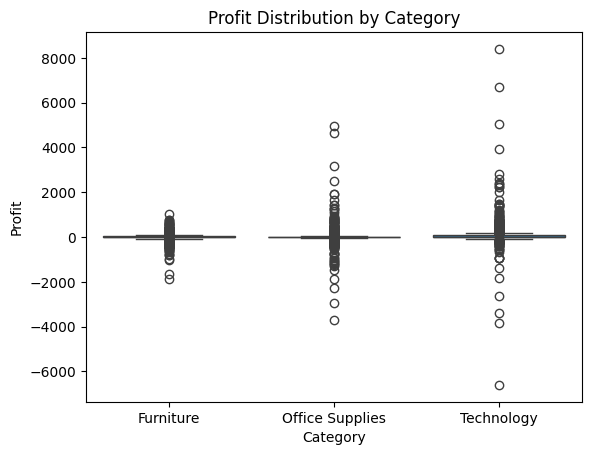

In [15]:
sns.boxplot(x='Category', y='Profit', data=df)
plt.title('Profit Distribution by Category')
plt.show()

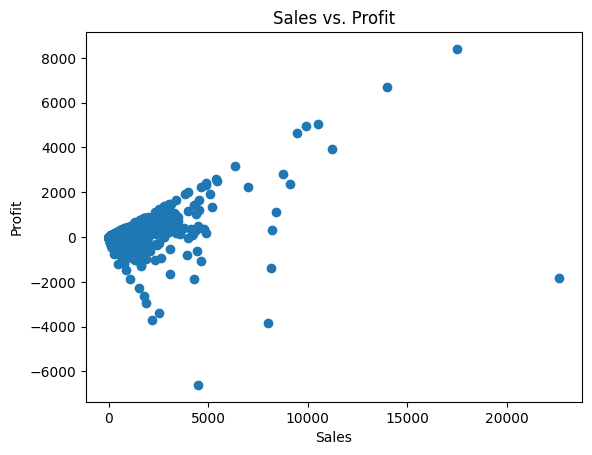

In [16]:
plt.scatter(df['Sales'], df['Profit'])
plt.title('Sales vs. Profit')
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.show()

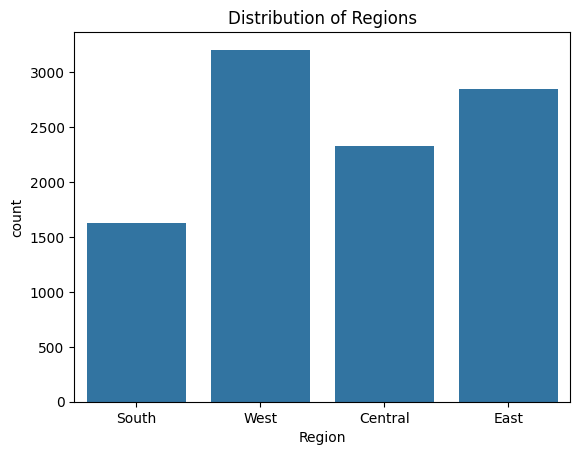

In [17]:
sns.countplot(x='Region', data=df)
plt.title('Distribution of Regions')
plt.show()

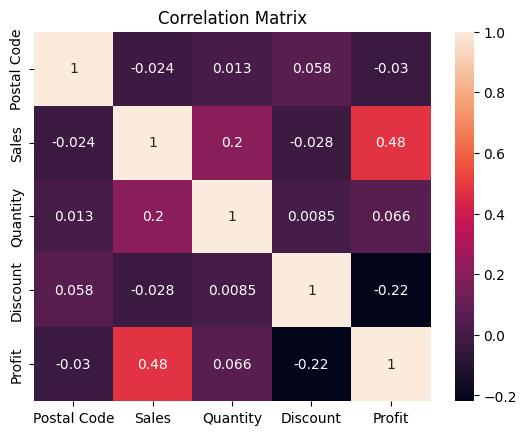

In [18]:
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

# Preprocessing

In [100]:
def categorize_profit(profit):
  if profit > 0:
    return 'Profit'
  else:
    return 'Non-Profit'

df['Profit_Category'] = df['Profit'].apply(categorize_profit)
df

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Profit_Category
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,Profit
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820,Profit
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714,Profit
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310,Non-Profit
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164,Profit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,First Class,Consumer,United States,Providence,Rhode Island,2908,East,Office Supplies,Paper,16.9000,5,0.00,7.7740,Profit
9996,Standard Class,Consumer,United States,Omaha,Nebraska,68104,Central,Technology,Phones,2479.9600,4,0.00,743.9880,Profit
9997,Standard Class,Consumer,United States,New York City,New York,10024,East,Office Supplies,Appliances,35.9100,3,0.00,9.6957,Profit
9998,Standard Class,Corporate,United States,New York City,New York,10011,East,Office Supplies,Storage,77.5500,5,0.00,20.1630,Profit


In [101]:
rows_needed = 10000 - len(df)
additional_data = df.sample(rows_needed, replace=True)
augmented_df = pd.concat([df, additional_data], ignore_index=True)
print("Jumlah baris setelah augmentasi:", len(augmented_df))

Jumlah baris setelah augmentasi: 10000


In [102]:
augmented_df.to_csv("Augmented_Superstore.csv", index=False)
df = pd.read_csv("Augmented_Superstore.csv")
df

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Profit_Category
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,Profit
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820,Profit
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714,Profit
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310,Non-Profit
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164,Profit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,First Class,Consumer,United States,Providence,Rhode Island,2908,East,Office Supplies,Paper,16.9000,5,0.00,7.7740,Profit
9996,Standard Class,Consumer,United States,Omaha,Nebraska,68104,Central,Technology,Phones,2479.9600,4,0.00,743.9880,Profit
9997,Standard Class,Consumer,United States,New York City,New York,10024,East,Office Supplies,Appliances,35.9100,3,0.00,9.6957,Profit
9998,Standard Class,Corporate,United States,New York City,New York,10011,East,Office Supplies,Storage,77.5500,5,0.00,20.1630,Profit


In [103]:
# Kolom kategorikal dan numerik
categorical_cols = ['Ship Mode', 'Segment', 'Category', 'Sub-Category', 'Profit_Category']
numerical_cols = ['Sales', 'Quantity', 'Discount']

In [104]:
# Fitur dan Target
X = df.drop(columns=['Profit_Category'])
y = df['Profit_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
# Preprocessing kolom numerik
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing kolom kategorikal
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing numerik dan kategorikal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols[:-1]),
    ])

# Apply preprocessor
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Transform target variables
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [106]:
# EarlyStopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model

## Feedforward Neural Network (FFNN)

In [107]:
# Model Feedforward Neural Network (FFNN)
model_ffnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model_ffnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [108]:
history_ffnn = model_ffnn.fit(
    X_train_processed,
    to_categorical(y_train_encoded),
    epochs=50,
    batch_size=32,
    validation_data=(X_test_processed, to_categorical(y_test_encoded)),
    callbacks=[early_stopping]
)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8588 - loss: 0.3391 - val_accuracy: 0.9405 - val_loss: 0.1433
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1437 - val_accuracy: 0.9380 - val_loss: 0.1374
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9385 - loss: 0.1391 - val_accuracy: 0.9410 - val_loss: 0.1358
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9412 - loss: 0.1284 - val_accuracy: 0.9405 - val_loss: 0.1321
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9444 - loss: 0.1253 - val_accuracy: 0.9395 - val_loss: 0.1258
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9393 - loss: 0.1298 - val_accuracy: 0.9400 - val_loss: 0.1234
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9392 - loss: 0.1311 - val_accuracy: 0.9400 - val_loss: 0.1308
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9496 - loss: 0.1175 - val_accuracy: 0.

In [109]:
# Prediksi model FFNN
predictions_ffnn = model_ffnn.predict(X_test_processed)
predictions_ffnn = np.argmax(predictions_ffnn, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [110]:
# Classification Report untuk FFNN
print("FFNN Classification Report:")
print(classification_report(y_test_encoded, predictions_ffnn))

FFNN Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       361
           1       0.96      0.97      0.96      1639

    accuracy                           0.94      2000
   macro avg       0.91      0.89      0.90      2000
weighted avg       0.94      0.94      0.94      2000



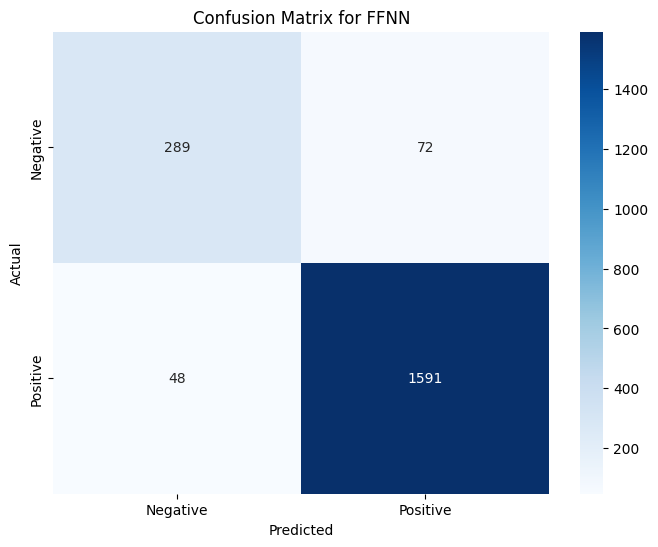

In [111]:
cm_ffnn = confusion_matrix(y_test_encoded, predictions_ffnn)

# Confusion Matrix FFNN
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ffnn, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for FFNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

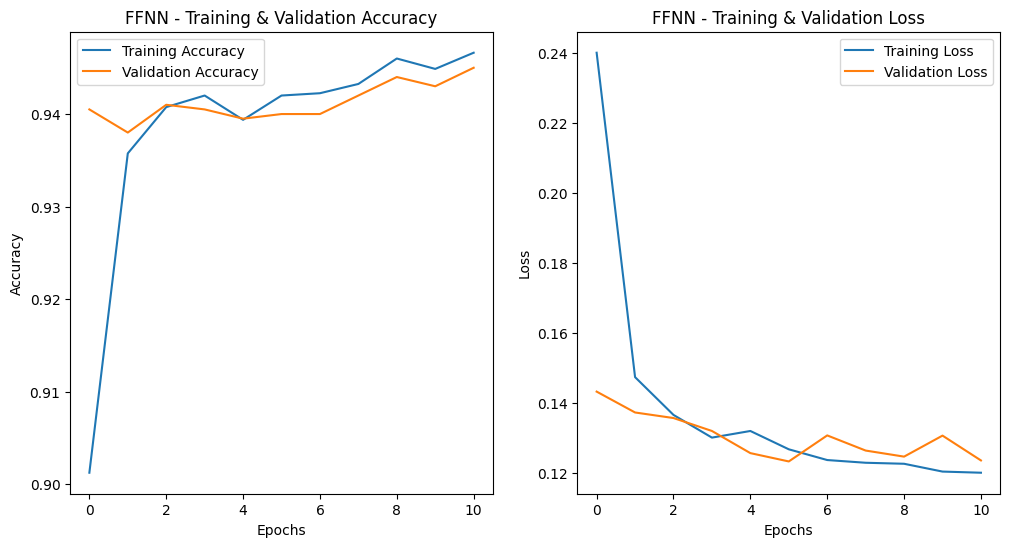

In [112]:
# Plotting untuk Model FFNN
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_ffnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_ffnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('FFNN - Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_ffnn.history['loss'], label='Training Loss')
plt.plot(history_ffnn.history['val_loss'], label='Validation Loss')
plt.title('FFNN - Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Deep Neural Network (DNN)

In [113]:
# Model Deep Neural Network (DNN)
model_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model_dnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [114]:
history_dnn = model_dnn.fit(
    X_train_processed,
    to_categorical(y_train_encoded),
    epochs=50,
    batch_size=32,
    validation_data=(X_test_processed, to_categorical(y_test_encoded)),
    callbacks=[early_stopping]
)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8577 - loss: 0.3281 - val_accuracy: 0.9380 - val_loss: 0.1488
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9354 - loss: 0.1526 - val_accuracy: 0.9410 - val_loss: 0.1431
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9395 - loss: 0.1434 - val_accuracy: 0.9350 - val_loss: 0.1340
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9411 - loss: 0.1356 - val_accuracy: 0.9445 - val_loss: 0.1294
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9414 - loss: 0.1314 - val_accuracy: 0.9400 - val_loss: 0.1330


In [115]:
# Prediksi model DNN
predictions_dnn = model_dnn.predict(X_test_processed)
predictions_dnn = np.argmax(predictions_dnn, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [116]:
# Classification Report untuk DNN
print("DNN Classification Report:")
print(classification_report(y_test_encoded, predictions_dnn))

DNN Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.76      0.82       361
           1       0.95      0.98      0.96      1639

    accuracy                           0.94      2000
   macro avg       0.91      0.87      0.89      2000
weighted avg       0.94      0.94      0.94      2000



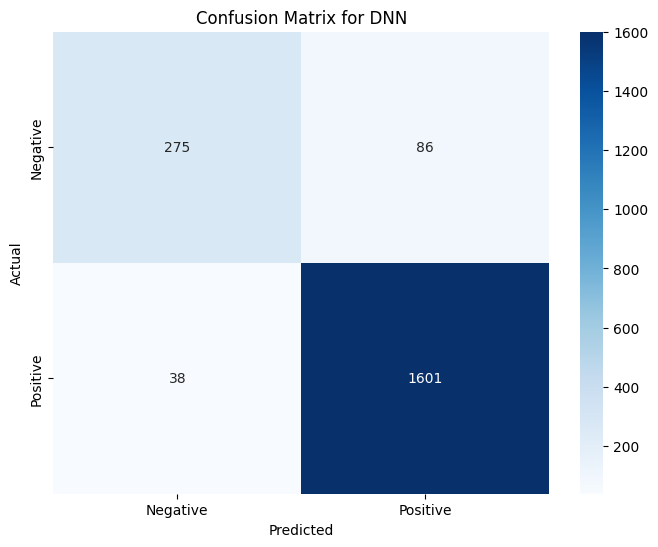

In [117]:
cm_dnn = confusion_matrix(y_test_encoded, predictions_dnn)

# Confusion Matrix DNN
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix for DNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

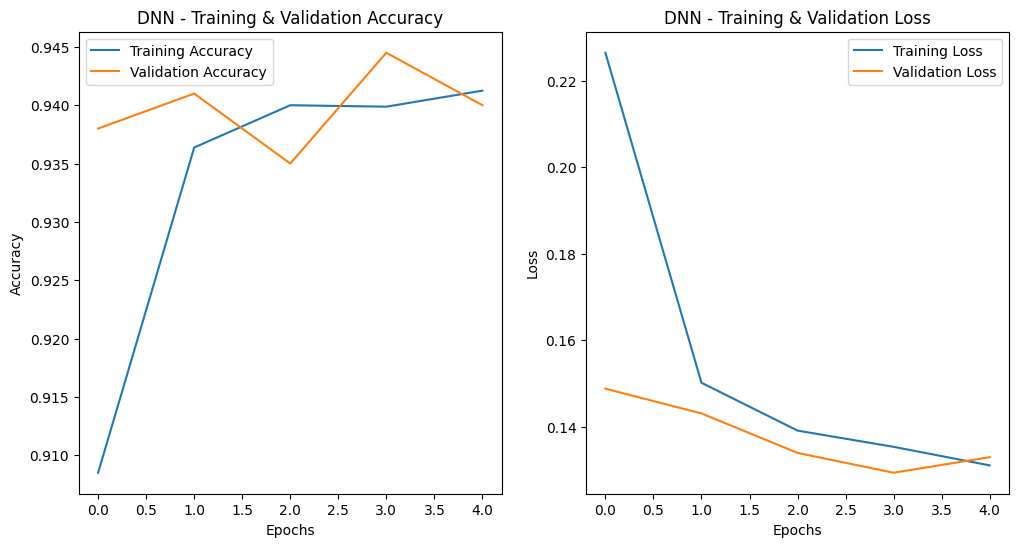

In [118]:
# Plotting untuk Model DNN
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('DNN - Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.title('DNN - Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Perbandingan Prediksi Model

In [119]:
# Membandingkan prediksi dengan nilai aktual
actual_values = y_test_encoded
predictions_ffnn = model_ffnn.predict(X_test_processed)
predicted_classes_ffnn = np.argmax(predictions_ffnn, axis=1)
predictions_dnn = model_dnn.predict(X_test_processed)
predicted_classes_dnn = np.argmax(predictions_dnn, axis=1)

# Menghitung jumlah prediksi yang benar dan salah
ffnn_correct = np.sum(predicted_classes_ffnn == actual_values)
ffnn_incorrect = np.sum(predicted_classes_ffnn != actual_values)
dnn_correct = np.sum(predicted_classes_dnn == actual_values)
dnn_incorrect = np.sum(predicted_classes_dnn != actual_values)

# Data untuk plot
models = ['FFNN', 'DNN']
correct_predictions = [ffnn_correct, dnn_correct]
incorrect_predictions = [ffnn_incorrect, dnn_incorrect]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


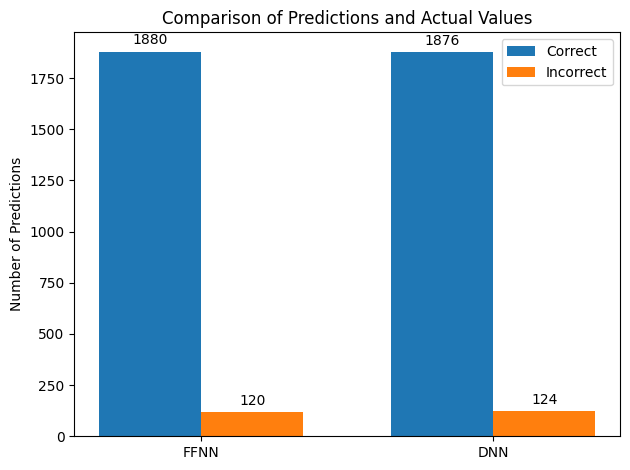

In [120]:
# Membuat plot
fig, ax = plt.subplots()
width = 0.35  # Lebar bar

rects1 = ax.bar(np.arange(len(models)), correct_predictions, width, label='Correct')
rects2 = ax.bar(np.arange(len(models)) + width, incorrect_predictions, width, label='Incorrect')

# Menambahkan label, judul, dan legenda
ax.set_ylabel('Number of Predictions')
ax.set_title('Comparison of Predictions and Actual Values')
ax.set_xticks(np.arange(len(models)) + width / 2)
ax.set_xticklabels(models)
ax.legend()

# Menambahkan label nilai di atas bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# Test Model untuk Prediksi

In [121]:
new_data = pd.DataFrame({
    'Sales': [500, 1200, 300, 1500, 800],
    'Quantity': [2, 4, 1, 5, 3],
    'Discount': [0.8, 0.15, 0.7, 0.05, 0.1],
    'Ship Mode': ['Standard Class', 'Second Class', 'First Class', 'Standard Class', 'Second Class'],
    'Segment': ['Consumer', 'Corporate', 'Home Office', 'Consumer', 'Corporate'],
    'Category': ['Furniture', 'Office Supplies', 'Technology', 'Furniture', 'Technology'],
    'Sub-Category': ['Chairs', 'Binders', 'Phones', 'Tables', 'Bookcases']
})

new_data_preprocessed = preprocessor.transform(new_data)

In [122]:
# Prediksi dengan model FFNN
predictions_ffnn = model_ffnn.predict(new_data_preprocessed)
predicted_classes_ffnn = np.argmax(predictions_ffnn, axis=1)

print("Prediksi Profit (FFNN):")
for i, pred in enumerate(predicted_classes_ffnn):
    print(f"Data {i+1}: {'Profit' if pred == 1 else 'Non-Profit'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Prediksi Profit (FFNN):
Data 1: Non-Profit
Data 2: Profit
Data 3: Non-Profit
Data 4: Profit
Data 5: Profit


In [123]:
# Prediksi dengan model DNN
predictions_dnn = model_dnn.predict(new_data_preprocessed)
predicted_classes_dnn = np.argmax(predictions_dnn, axis=1)

print("Prediksi Profit (DNN):")
for i, pred in enumerate(predicted_classes_dnn):
    print(f"Data {i+1}: {'Profit' if pred == 1 else 'No Profit'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediksi Profit (DNN):
Data 1: No Profit
Data 2: Profit
Data 3: No Profit
Data 4: Profit
Data 5: Profit


# Save Model

In [124]:
drive.mount('/content/drive')

# Simpan preprocessor
joblib.dump(preprocessor, '/content/drive/MyDrive/Study/Machine Learning/UAP/preprocessor.joblib')

# Simpan model
model_ffnn.save('/content/drive/MyDrive/Study/Machine Learning/UAP/model_ffnn.h5')
model_dnn.save('/content/drive/MyDrive/Study/Machine Learning/UAP/model_dnn.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
